# Implementation of "Fair Decisions Despite Imperfect Predictions" using the covariance fairness constraint

In [2]:
import numpy as np
from src.consequential_learning import train
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility, demographic_parity

## The parameters used by the the original authors  

In [3]:
dim_x = 1
training_parameters = {
    'use_sensitve_attributes': False,
    'time_steps':200,
    'batch_size':512,
    'num_iterations': 32,
    'learning_parameters': {
        'learning_rate': 0.5,
        'decay_rate': 0.8,
        'decay_step': 30
    },
    'fairness_rate':0,
    'fraction_protected':0.3,
    'num_test_samples': 5000,
    'bias': True,
    'benefit_value_function': demographic_parity
}
training_parameters['dim_theta'] = dim_x + 1 if training_parameters['bias'] else dim_x
training_parameters['feature_map'] = IdentityFeatureMap(training_parameters['dim_theta'])
training_parameters['num_decisions'] = training_parameters['num_iterations'] * training_parameters['batch_size']
training_parameters['utility_value_function'] = lambda **util_params : cost_utility(cost_factor=0.55, **util_params)

## Definition of the fairness function  
The covariance fairness constraint is defined as the covariance between the sensitive attribute and the signed distance from the users feature vectors to the decision boundary: $$Cov_{DI}(s, d_{\theta}) = E[(s - \mu_s)e]$$

In [4]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    y = fairness_kwargs["y"]
    s = fairness_kwargs["s"]
    decisions = fairness_kwargs["decisions"].reshape(-1, 1)
    gradient = fairness_kwargs["gradient"]
    sampling_theta = fairness_kwargs["sampling_theta"]

    mu_s = policy._calculate_expectation(x, s, s.astype(float), False, sampling_theta).reshape(-1, 1)
    covariance = (s - mu_s) * decisions

    return policy._calculate_expectation(x, s, covariance, gradient, sampling_theta)

training_parameters['fairness_function'] = fairness_function

## Train the model

In [5]:
i = 1
utilities = []
benefit_deltas = []

for _, utility, benefit_delta in train(**training_parameters):
    utilities.append(utility)
    benefit_deltas.append(benefit_delta)
    i += 1

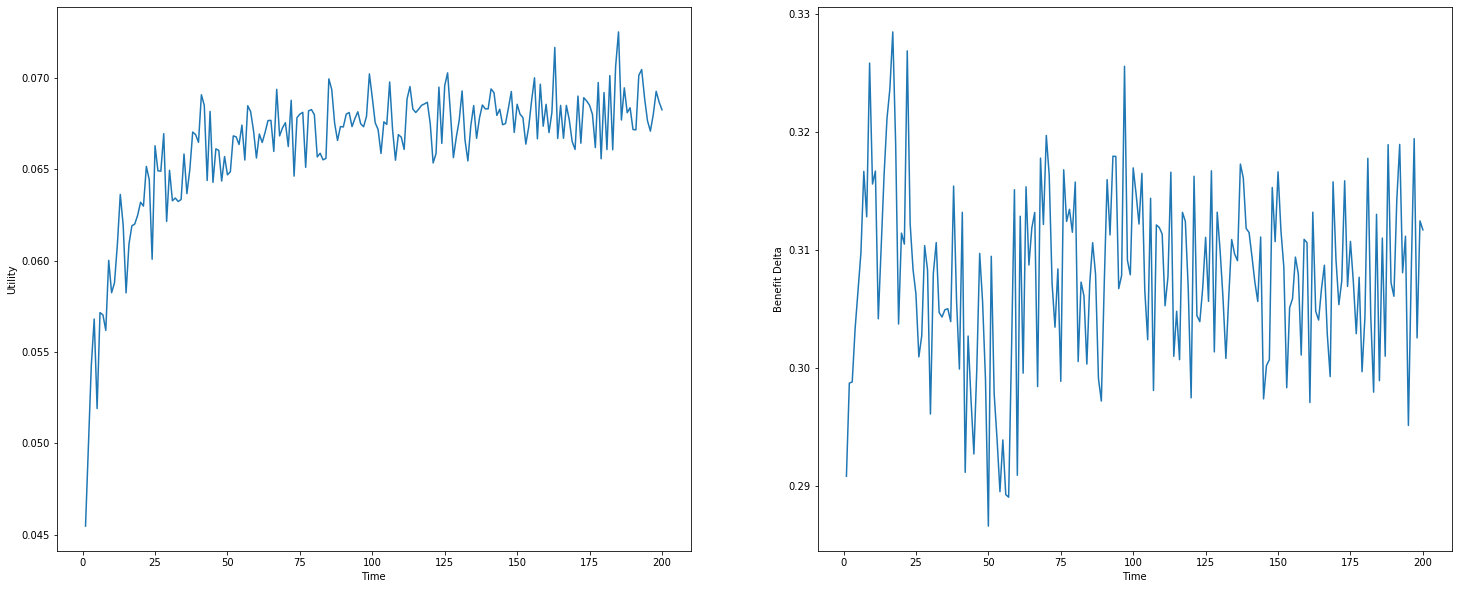

In [6]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(25,10))
ax1.plot(range(1, len(utilities) + 1), utilities)
ax1.set_xlabel("Time")
ax1.set_ylabel("Utility")
ax2.plot(range(1, len(benefit_deltas) + 1), benefit_deltas)
ax2.set_xlabel("Time")
ax2.set_ylabel("Benefit Delta")
plt.show()